In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [153]:
Jordan_df=pd.read_csv('Data/크림_조던_제품거래량_전처리_진짜x2최종.csv')

In [154]:
Jordan_df

,index,사이즈,거래가,거래일,제품한글명,모델번호,출시일,컬러,발매가,총거래량,...,SILVER,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX
0,804.0,275,623000,202207,조던 1 레트로 하이 OG 블랙 모카,555088-105,202011,"['SAIL', 'BLACK', 'MOCHA']",199000.0,2490,...,0,1,0,1,0,1,0,0,0,0
1,804.0,265,620000,202207,조던 1 레트로 하이 OG 블랙 모카,555088-105,202011,"['SAIL', 'BLACK', 'MOCHA']",199000.0,2490,...,0,1,0,1,0,1,0,0,0,0
2,804.0,285,602000,202207,조던 1 레트로 하이 OG 블랙 모카,555088-105,202011,"['SAIL', 'BLACK', 'MOCHA']",199000.0,2490,...,0,1,0,1,0,1,0,0,0,0
3,804.0,270,760000,202207,조던 1 레트로 하이 OG 블랙 모카,555088-105,202011,"['SAIL', 'BLACK', 'MOCHA']",199000.0,2490,...,0,1,0,1,0,1,0,0,0,0
4,804.0,265,610000,202207,조던 1 레트로 하이 OG 블랙 모카,555088-105,202011,"['SAIL', 'BLACK', 'MOCHA']",199000.0,2490,...,0,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185842,4545.0,270,550000,202104,조던 1 레트로 하이 이퀄리티 BHM 2018,AQ7474-001,201801,"['WHITE', 'BLACK']",189300.0,9,...,0,1,1,0,0,0,0,0,0,0
185843,4545.0,275,620000,202104,조던 1 레트로 하이 이퀄리티 BHM 2018,AQ7474-001,201801,"['WHITE', 'BLACK']",189300.0,9,...,0,1,1,0,0,0,0,0,0,0
185844,4545.0,250,440000,202104,조던 1 레트로 하이 이퀄리티 BHM 2018,AQ7474-001,201801,"['WHITE', 'BLACK']",189300.0,9,...,0,1,1,0,0,0,0,0,0,0
185845,4545.0,250,400000,202103,조던 1 레트로 하이 이퀄리티 BHM 2018,AQ7474-001,201801,"['WHITE', 'BLACK']",189300.0,9,...,0,1,1,0,0,0,0,0,0,0


In [155]:
Jordan_df.dtypes

index       float64
사이즈           int64
거래가           int64
거래일           int64
제품한글명        object
모델번호         object
출시일           int64
컬러           object
발매가         float64
총거래량          int64
RED           int64
ORANGE        int64
STARFISH      int64
YELLOW        int64
GREEN         int64
BLUE          int64
CORAL         int64
PINK          int64
PURPLE        int64
GREY          int64
SILVER        int64
BLACK         int64
WHITE         int64
MOCHA         int64
STEALTH       int64
SAIL          int64
NAVY          int64
BROWN         int64
WHEAT         int64
BORDEAUX      int64
dtype: object

In [156]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(Jordan_df,test_size=0.3,shuffle=True,random_state=10000)

In [157]:
train_df

,index,사이즈,거래가,거래일,제품한글명,모델번호,출시일,컬러,발매가,총거래량,...,SILVER,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX
138330,3387.0,250,350000,202102,조던 11 레트로 로우 바론스,528895-010,201705,"['WHITE', 'SILVER', 'BLACK']",228200.0,232,...,1,1,1,0,0,0,0,0,0,0
107419,3232.0,240,189000,202201,(GS) 조던 11 레트로 쿨 그레이 2021,378038-005,202112,"['WHITE', 'GREY']",219000.0,338,...,0,0,1,0,0,0,0,0,0,0
70207,3074.0,245,245000,202206,(W) 조던 1 미드 화이트 하이퍼 로얄,BQ6472-104,202107,['WHITE'],139000.0,4535,...,0,0,1,0,0,0,0,0,0,0
68464,3066.0,230,200000,202105,(W) 조던 1 줌 에어 컴포트 라이트 본,CT0979-002,202105,"['WHITE', 'BLACK']",169000.0,2826,...,0,1,1,0,0,0,0,0,0,0
42296,3045.0,225,167000,202105,(GS) 조던 1 미드 짐레드 블랙 화이트,DJ4695-122,202103,"['WHITE', 'BLACK', 'RED']",109000.0,4034,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68585,3066.0,245,212000,202105,(W) 조던 1 줌 에어 컴포트 라이트 본,CT0979-002,202105,"['WHITE', 'BLACK']",169000.0,2826,...,0,1,1,0,0,0,0,0,0,0
59394,3062.0,265,245000,202108,조던 11 레트로 로우 레전드 블루,AV2187-117,202104,"['WHITE', 'BLACK', 'BLUE']",219000.0,2302,...,0,1,1,0,0,0,0,0,0,0
113967,3243.0,265,240000,202004,조던 6 레트로 인프라레드 2019,384664-060,201902,['BLACK'],260600.0,553,...,0,1,0,0,0,0,0,0,0,0
157992,3593.0,255,635000,202103,조던 1 로우 OG 차이니즈 뉴 이어,DD2233-001,202101,"['WHITE', 'BLACK', 'RED']",169500.0,44,...,0,1,1,0,0,0,0,0,0,0


In [158]:
test_df

,index,사이즈,거래가,거래일,제품한글명,모델번호,출시일,컬러,발매가,총거래량,...,SILVER,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX
36867,3042.0,270,270000,202008,조던 3 레트로 팅커 햇필드,AQ3835-160,201803,"['WHITE', 'GREY', 'BLACK', 'RED']",259600.0,186,...,0,1,1,0,0,0,0,0,0,0
183847,4163.0,270,130000,202008,조던 1 카고 블랙 화이트,CD6757-001,201905,"['WHITE', 'SILVER', 'ORANGE', 'BLACK', 'RED']",169500.0,8,...,1,1,1,0,0,0,0,0,0,0
149012,3510.0,260,188000,202102,조던 1 로우 SE USA,CZ8454-400,202007,"['WHITE', 'RED', 'NAVY']",129000.0,326,...,0,0,1,0,0,0,1,0,0,0
51717,3052.0,220,241000,202205,(W) 조던 1 엘리베이트 로우 SE 화이트 오닉스,DH7004-102,202202,['WHITE'],159000.0,2002,...,0,0,1,0,0,0,0,0,0,0
162499,3668.0,265,280000,202005,조던 1.5 레트로 리버스 프라그먼트,768861-106,201510,"['WHITE', 'BLACK']",195600.0,31,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37337,3043.0,275,283000,202203,조던 1 미드 SE 파인 그린 라이트 스모크 그레이,DC7294-103,202112,"['WHITE', 'GREY', 'GREEN']",159000.0,1893,...,0,0,1,0,0,0,0,0,0,0
117839,3250.0,220,235000,202104,(GS) 조던 11 레트로 브레드 2019,378038-061,201912,"['WHITE', 'BLACK', 'RED']",209000.0,361,...,0,1,1,0,0,0,0,0,0,0
167271,3778.0,255,600000,202012,조던 1 로우 SB 코스턴 미드나잇 네이비,CJ7891-400,201906,"['WHITE', 'SILVER', 'NAVY']",143500.0,84,...,1,0,1,0,0,0,1,0,0,0
42308,3045.0,225,161000,202105,(GS) 조던 1 미드 짐레드 블랙 화이트,DJ4695-122,202103,"['WHITE', 'BLACK', 'RED']",109000.0,4034,...,0,1,1,0,0,0,0,0,0,0


In [159]:
#test data에서 예측변수 '거래가'는 제외
y_test = test_df['거래가']
test_df=test_df.drop(columns='거래가')

In [160]:
test_df

,index,사이즈,거래일,제품한글명,모델번호,출시일,컬러,발매가,총거래량,RED,...,SILVER,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX
36867,3042.0,270,202008,조던 3 레트로 팅커 햇필드,AQ3835-160,201803,"['WHITE', 'GREY', 'BLACK', 'RED']",259600.0,186,1,...,0,1,1,0,0,0,0,0,0,0
183847,4163.0,270,202008,조던 1 카고 블랙 화이트,CD6757-001,201905,"['WHITE', 'SILVER', 'ORANGE', 'BLACK', 'RED']",169500.0,8,1,...,1,1,1,0,0,0,0,0,0,0
149012,3510.0,260,202102,조던 1 로우 SE USA,CZ8454-400,202007,"['WHITE', 'RED', 'NAVY']",129000.0,326,1,...,0,0,1,0,0,0,1,0,0,0
51717,3052.0,220,202205,(W) 조던 1 엘리베이트 로우 SE 화이트 오닉스,DH7004-102,202202,['WHITE'],159000.0,2002,0,...,0,0,1,0,0,0,0,0,0,0
162499,3668.0,265,202005,조던 1.5 레트로 리버스 프라그먼트,768861-106,201510,"['WHITE', 'BLACK']",195600.0,31,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37337,3043.0,275,202203,조던 1 미드 SE 파인 그린 라이트 스모크 그레이,DC7294-103,202112,"['WHITE', 'GREY', 'GREEN']",159000.0,1893,0,...,0,0,1,0,0,0,0,0,0,0
117839,3250.0,220,202104,(GS) 조던 11 레트로 브레드 2019,378038-061,201912,"['WHITE', 'BLACK', 'RED']",209000.0,361,1,...,0,1,1,0,0,0,0,0,0,0
167271,3778.0,255,202012,조던 1 로우 SB 코스턴 미드나잇 네이비,CJ7891-400,201906,"['WHITE', 'SILVER', 'NAVY']",143500.0,84,0,...,1,0,1,0,0,0,1,0,0,0
42308,3045.0,225,202105,(GS) 조던 1 미드 짐레드 블랙 화이트,DJ4695-122,202103,"['WHITE', 'BLACK', 'RED']",109000.0,4034,1,...,0,1,1,0,0,0,0,0,0,0


In [161]:
train_df.describe()

,index,사이즈,거래가,거래일,출시일,발매가,총거래량,RED,ORANGE,STARFISH,...,SILVER,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX
count,130092.000000,130092.000000,1.300920e+05,130092.000000,130092.000000,1.300920e+05,130092.000000,130092.000000,130092.000000,130092.000000,...,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000,130092.000000
mean,3175.830259,254.003129,3.162639e+05,202132.338322,202032.661693,1.695437e+05,1715.024444,0.236832,0.050741,0.007256,...,0.054423,0.692348,0.821311,0.015143,0.001430,0.093188,0.033207,0.009140,0.000284,0.019932
std,988.850927,28.786160,4.738796e+05,68.426926,159.478898,7.902934e+04,1886.812652,0.425140,0.219469,0.084875,...,0.226851,0.461523,0.383093,0.122123,0.037785,0.290697,0.179178,0.095164,0.016862,0.139767
min,804.000000,70.000000,3.000000e+04,202002.000000,199401.000000,3.900000e+04,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3049.000000,240.000000,1.650000e+05,202104.000000,202007.000000,1.306000e+05,144.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3099.000000,260.000000,2.150000e+05,202110.000000,202102.000000,1.590000e+05,875.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3396.000000,275.000000,2.900000e+05,202204.000000,202108.000000,1.990000e+05,2826.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18500.000000,330.000000,1.345000e+07,202208.000000,202207.000000,3.000000e+06,6644.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [162]:
train_df['제품한글명'].value_counts()[:20]

조던 1 로우 골프 울프 그레이                              4649
조던 1 미드 브레드 밴드 2020                            3559
조던 1 x 트래비스 스캇 x 프라그먼트 레트로 로우 OG SP 밀리터리 블루    3404
조던 1 레트로 하이 OG 볼트 골드                           3362
조던 1 레트로 하이 OG 일렉트로 오렌지                        3155
(W) 조던 1 미드 화이트 하이퍼 로얄                         3152
(W) 조던 1 레트로 하이 실버토                            2857
(GS) 조던 1 미드 짐레드 블랙 화이트                        2755
조던 1 로우 하이퍼 로얄                                 2194
조던 1 로우 SE 초콜릿 블리스                             2126
(W) 조던 1 레트로 하이 사틴 레드                          1993
(W) 조던 1 줌 에어 컴포트 라이트 본                        1950
조던 1 로우 다크 파우더 블루                              1730
조던 1 레트로 하이 OG 블랙 모카                           1705
(GS) 조던 1 레트로 하이 OG 보르도                        1658
조던 11 레트로 로우 레전드 블루                            1580
(W) 조던 1 엘리베이트 로우 SE 화이트 오닉스                   1414
조던 1 미드 트리플 화이트                                1374
조던 1 하이 85 뉴트럴 그레이                             1371
(W) 조던 1 미드 

In [163]:
#제품별 거래가 평균 내림차순 정렬
product_price = train_df.groupby('제품한글명')['거래가'].agg('mean').sort_values(ascending=False)
pd.DataFrame(product_price[:10])

,거래가
제품한글명,
조던 1 x 디올 하이 OG,1.106167e+07
조던 1 x 디올 로우 OG,8.775862e+06
조던 1 x 오프화이트 레트로 하이 시카고 더 텐,7.621396e+06
조던 1 x 오프화이트 레트로 하이 화이트,6.508333e+06
조던 1 레트로 하이 밴드 2011,5.000000e+06
조던 1 x 프라그먼트 레트로 하이 OG,4.917517e+06
조던 1 x 트래비스 스캇 x 프라그먼트 레트로 하이 OG SP 밀리터리 블루,4.290722e+06
조던 1 x 트로피 룸 레트로 하이 OG SP 시카고 (프렌즈 앤 패밀리),3.901214e+06
조던 4 x 카우스 레트로 쿨 그레이,3.550000e+06


### 색상

In [164]:
train_df.dtypes

index       float64
사이즈           int64
거래가           int64
거래일           int64
제품한글명        object
모델번호         object
출시일           int64
컬러           object
발매가         float64
총거래량          int64
RED           int64
ORANGE        int64
STARFISH      int64
YELLOW        int64
GREEN         int64
BLUE          int64
CORAL         int64
PINK          int64
PURPLE        int64
GREY          int64
SILVER        int64
BLACK         int64
WHITE         int64
MOCHA         int64
STEALTH       int64
SAIL          int64
NAVY          int64
BROWN         int64
WHEAT         int64
BORDEAUX      int64
dtype: object

In [165]:
color_ex=['RED', 'ORANGE', 'STARFISH', 'YELLOW', 'GREEN', 'BLUE', 'CORAL', 'PINK', 'PURPLE','GREY', 'SILVER', 'BLACK', 'WHITE', 'MOCHA', 'STEALTH', 'SAIL', 'NAVY', 'BROWN', 'WHEAT', 'BORDEAUX']
color_price=[]

for color in color_ex:
    color_price.append(round(train_df[train_df[color]==1]['거래가'].mean(),2))

In [166]:
color_df = pd.DataFrame(columns=['color','mean'])
color_df['color'] = color_ex
color_df['mean'] = color_price
color_df = color_df.sort_values(by='mean',ascending=False)
color_df = color_df.reset_index(drop=True)
color_df

,color,mean
0,SAIL,935756.74
1,MOCHA,741368.02
2,BLUE,594900.06
3,STARFISH,387087.92
4,BLACK,346757.91
5,RED,335387.93
6,GREY,299831.31
7,PINK,287645.20
8,WHITE,263769.55
9,SILVER,251341.24


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'SAIL'),
  Text(1, 0, 'MOCHA'),
  Text(2, 0, 'BLUE'),
  Text(3, 0, 'STARFISH'),
  Text(4, 0, 'BLACK'),
  Text(5, 0, 'RED'),
  Text(6, 0, 'GREY'),
  Text(7, 0, 'PINK'),
  Text(8, 0, 'WHITE'),
  Text(9, 0, 'SILVER'),
  Text(10, 0, 'WHEAT'),
  Text(11, 0, 'GREEN'),
  Text(12, 0, 'NAVY'),
  Text(13, 0, 'PURPLE'),
  Text(14, 0, 'ORANGE'),
  Text(15, 0, 'BROWN'),
  Text(16, 0, 'YELLOW'),
  Text(17, 0, 'BORDEAUX'),
  Text(18, 0, 'STEALTH'),
  Text(19, 0, 'CORAL')])

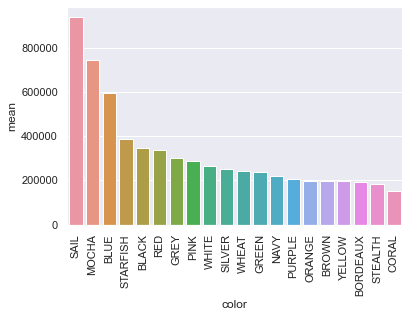

In [167]:
sns.barplot(x='color',y='mean',data=color_df)
plt.xticks(rotation =90)

### 거래가

C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 864x432 with 0 Axes>

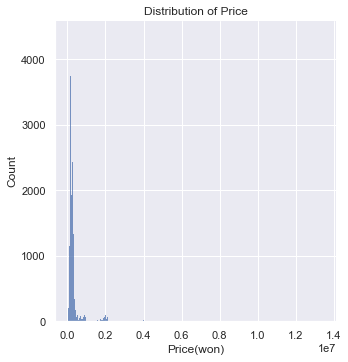

In [168]:
# Target data - train price
plt.figure(figsize=(12,6))
sns.displot(train_df['거래가'], bins="auto")
plt.xlabel('Price(won)')
plt.title('Distribution of Price')
plt.show()

In [169]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['거래가'])
real_price = train_df['거래가'] # 원래 가격
train_df.drop('거래가', axis=1, inplace=True)
train_df.head(1)

,index,사이즈,거래일,제품한글명,모델번호,출시일,컬러,발매가,총거래량,RED,...,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX,log_price
138330,3387.0,250,202102,조던 11 레트로 로우 바론스,528895-010,201705,"['WHITE', 'SILVER', 'BLACK']",228200.0,232,0,...,1,1,0,0,0,0,0,0,0,12.765691


- 가격의 분포가 매우 왼쪽으로 치우침
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있으니,
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

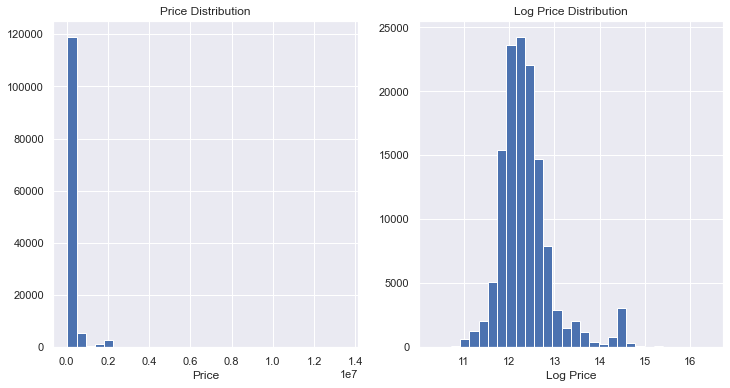

In [170]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train_df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

### 발매가

C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 864x432 with 0 Axes>

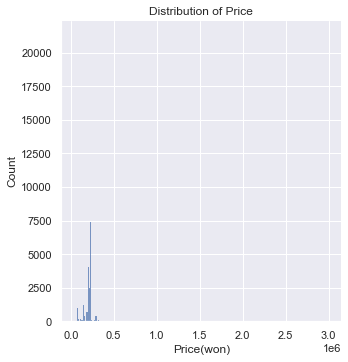

In [171]:
# Target data - train price
plt.figure(figsize=(12,6))
sns.displot(train_df['발매가'], bins="auto")
plt.xlabel('Price(won)')
plt.title('Distribution of Price')
plt.show()

In [172]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price_transaction'] = np.log1p(train_df['발매가'])
real_price = train_df['발매가'] # 원래 가격
train_df.drop('발매가', axis=1, inplace=True)
train_df.head(1)

,index,사이즈,거래일,제품한글명,모델번호,출시일,컬러,총거래량,RED,ORANGE,...,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX,log_price,log_price_transaction
138330,3387.0,250,202102,조던 11 레트로 로우 바론스,528895-010,201705,"['WHITE', 'SILVER', 'BLACK']",232,0,0,...,1,0,0,0,0,0,0,0,12.765691,12.337982


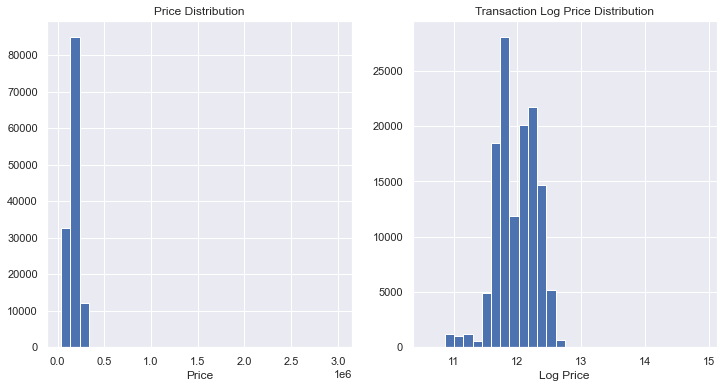

In [173]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train_df['log_price_transaction'], bins=30)
ax2.set_title('Transaction Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 864x432 with 0 Axes>

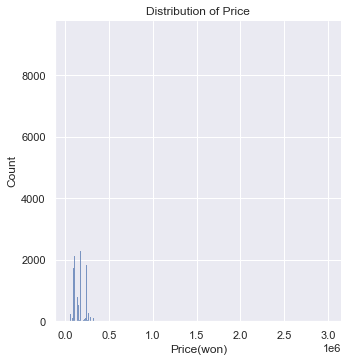

In [174]:
# Target data - train price
plt.figure(figsize=(12,6))
sns.displot(test_df['발매가'], bins="auto")
plt.xlabel('Price(won)')
plt.title('Distribution of Price')
plt.show()

In [175]:
# 가격 로그 변환 후 원래 가격 따로 저장
test_df['log_price_transaction'] = np.log1p(test_df['발매가'])
real_price = test_df['발매가'] # 원래 가격
test_df.drop('발매가', axis=1, inplace=True)
test_df.head(1)

,index,사이즈,거래일,제품한글명,모델번호,출시일,컬러,총거래량,RED,ORANGE,...,BLACK,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX,log_price_transaction
36867,3042.0,270,202008,조던 3 레트로 팅커 햇필드,AQ3835-160,201803,"['WHITE', 'GREY', 'BLACK', 'RED']",186,1,0,...,1,1,0,0,0,0,0,0,0,12.466901


### 사이즈

In [176]:
train_df['사이즈'].sort_values(ascending=True)

183654     70
184747     70
173940     70
166122     70
183642     70
         ... 
145837    320
124596    320
92099     320
24121     330
143151    330
Name: 사이즈, Length: 130092, dtype: int64

C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\gi257\.anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51592 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 432x288 with 0 Axes>

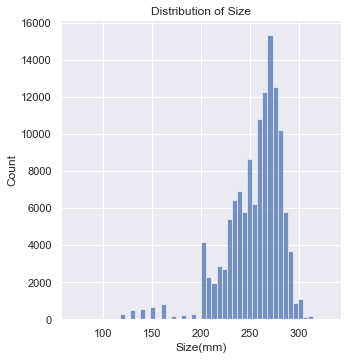

In [177]:
# Target data - train price
plt.figure()
sns.displot(train_df['사이즈'], bins=50)
plt.xlabel('Size(mm)')
plt.title('Distribution of Size')
plt.show()

### Date

In [178]:
train_df.head(1)

,index,사이즈,거래일,제품한글명,모델번호,출시일,컬러,총거래량,RED,ORANGE,...,WHITE,MOCHA,STEALTH,SAIL,NAVY,BROWN,WHEAT,BORDEAUX,log_price,log_price_transaction
138330,3387.0,250,202102,조던 11 레트로 로우 바론스,528895-010,201705,"['WHITE', 'SILVER', 'BLACK']",232,0,0,...,1,0,0,0,0,0,0,0,12.765691,12.337982


In [179]:
train_df['거래일']=train_df['거래일'].astype('str')
train_df['출시일']=train_df['출시일'].astype('str')

In [180]:
test_df['거래일']=test_df['거래일'].astype('str')
test_df['출시일']=test_df['출시일'].astype('str')

In [181]:
from datetime import datetime
date = lambda x: datetime.strptime(x, "%Y%m" )
year = lambda x: datetime.strptime(x, "%Y%m" ).year
month = lambda x: datetime.strptime(x, "%Y%m" ).month

train_df['거래년도'] = train_df['거래일'].map(year)
train_df['거래월'] = train_df['거래일'].map(month)

In [182]:
date = lambda x: datetime.strptime(x, "%Y%m" )
year = lambda x: datetime.strptime(x, "%Y%m" ).year
month = lambda x: datetime.strptime(x, "%Y%m" ).month

train_df['출시년도'] = train_df['출시일'].map(year)
train_df['출시월'] = train_df['출시일'].map(month)

In [183]:
from datetime import datetime
date = lambda x: datetime.strptime(x, "%Y%m" )
year = lambda x: datetime.strptime(x, "%Y%m" ).year
month = lambda x: datetime.strptime(x, "%Y%m" ).month

test_df['거래년도'] = test_df['거래일'].map(year)
test_df['거래월'] = test_df['거래일'].map(month)

date = lambda x: datetime.strptime(x, "%Y%m" )
year = lambda x: datetime.strptime(x, "%Y%m" ).year
month = lambda x: datetime.strptime(x, "%Y%m" ).month

test_df['출시년도'] = test_df['출시일'].map(year)
test_df['출시월'] = test_df['출시일'].map(month)

In [184]:
test_df.dtypes

index                    float64
사이즈                        int64
거래일                       object
제품한글명                     object
모델번호                      object
출시일                       object
컬러                        object
총거래량                       int64
RED                        int64
ORANGE                     int64
STARFISH                   int64
YELLOW                     int64
GREEN                      int64
BLUE                       int64
CORAL                      int64
PINK                       int64
PURPLE                     int64
GREY                       int64
SILVER                     int64
BLACK                      int64
WHITE                      int64
MOCHA                      int64
STEALTH                    int64
SAIL                       int64
NAVY                       int64
BROWN                      int64
WHEAT                      int64
BORDEAUX                   int64
log_price_transaction    float64
거래년도                       int64
거래월       

# Modeling

In [185]:
drop_columns = ['거래일','제품한글명','모델번호','출시일','컬러']
train_df = train_df.drop(drop_columns,axis=1)

In [186]:
train_X, train_y = train_df.drop('log_price', axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(130092, 28) (130092,)


## Score

In [187]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

## Model

In [188]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [59]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


1 FOLDS: LinearRegression RMSLE: 0.4161
2 FOLDS: LinearRegression RMSLE: 0.4071
3 FOLDS: LinearRegression RMSLE: 0.4150
4 FOLDS: LinearRegression RMSLE: 0.4401
5 FOLDS: LinearRegression RMSLE: 0.4370
6 FOLDS: LinearRegression RMSLE: 0.4249
7 FOLDS: LinearRegression RMSLE: 0.4210
8 FOLDS: LinearRegression RMSLE: 0.4234
9 FOLDS: LinearRegression RMSLE: 0.4194
10 FOLDS: LinearRegression RMSLE: 0.4112

LinearRegression mean RMSLE: 0.4215


Ridge Cross Validations...: 100%|██████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.50it/s]


1 FOLDS: Ridge RMSLE: 0.4161
2 FOLDS: Ridge RMSLE: 0.4072
3 FOLDS: Ridge RMSLE: 0.4150
4 FOLDS: Ridge RMSLE: 0.4401
5 FOLDS: Ridge RMSLE: 0.4370
6 FOLDS: Ridge RMSLE: 0.4249
7 FOLDS: Ridge RMSLE: 0.4210
8 FOLDS: Ridge RMSLE: 0.4234
9 FOLDS: Ridge RMSLE: 0.4194
10 FOLDS: Ridge RMSLE: 0.4112

Ridge mean RMSLE: 0.4215


Lasso Cross Validations...: 100%|██████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]


1 FOLDS: Lasso RMSLE: 0.4260
2 FOLDS: Lasso RMSLE: 0.4178
3 FOLDS: Lasso RMSLE: 0.4294
4 FOLDS: Lasso RMSLE: 0.4555
5 FOLDS: Lasso RMSLE: 0.4491
6 FOLDS: Lasso RMSLE: 0.4358
7 FOLDS: Lasso RMSLE: 0.4318
8 FOLDS: Lasso RMSLE: 0.4342
9 FOLDS: Lasso RMSLE: 0.4311
10 FOLDS: Lasso RMSLE: 0.4206

Lasso mean RMSLE: 0.4331


ElasticNet Cross Validations...: 100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


1 FOLDS: ElasticNet RMSLE: 0.4233
2 FOLDS: ElasticNet RMSLE: 0.4168
3 FOLDS: ElasticNet RMSLE: 0.4275
4 FOLDS: ElasticNet RMSLE: 0.4533
5 FOLDS: ElasticNet RMSLE: 0.4475
6 FOLDS: ElasticNet RMSLE: 0.4333
7 FOLDS: ElasticNet RMSLE: 0.4291
8 FOLDS: ElasticNet RMSLE: 0.4327
9 FOLDS: ElasticNet RMSLE: 0.4286
10 FOLDS: ElasticNet RMSLE: 0.4188

ElasticNet mean RMSLE: 0.4311


DecisionTreeRegressor Cross Validations...: 100%|██████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.3306
2 FOLDS: DecisionTreeRegressor RMSLE: 0.3261
3 FOLDS: DecisionTreeRegressor RMSLE: 0.3240
4 FOLDS: DecisionTreeRegressor RMSLE: 0.3319
5 FOLDS: DecisionTreeRegressor RMSLE: 0.3340
6 FOLDS: DecisionTreeRegressor RMSLE: 0.3300
7 FOLDS: DecisionTreeRegressor RMSLE: 0.3347
8 FOLDS: DecisionTreeRegressor RMSLE: 0.3230
9 FOLDS: DecisionTreeRegressor RMSLE: 0.3265
10 FOLDS: DecisionTreeRegressor RMSLE: 0.3262

DecisionTreeRegressor mean RMSLE: 0.3287


RandomForestRegressor Cross Validations...:   0%|                                               | 0/10 [00:00<?, ?it/s]C:\Users\gi257\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
RandomForestRegressor Cross Validations...:  10%|███▉                                   | 1/10 [00:07<01:10,  7.87s/it]C:\Users\gi257\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
RandomForestRegressor Cross Validations...:  20%|███████▊                               | 2/10 [00:24<01:42, 12.87s/it]C:\Users\gi257\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and w

1 FOLDS: RandomForestRegressor RMSLE: 0.2642
2 FOLDS: RandomForestRegressor RMSLE: 0.2523
3 FOLDS: RandomForestRegressor RMSLE: 0.2461
4 FOLDS: RandomForestRegressor RMSLE: 0.2550
5 FOLDS: RandomForestRegressor RMSLE: 0.2506
6 FOLDS: RandomForestRegressor RMSLE: 0.2510
7 FOLDS: RandomForestRegressor RMSLE: 0.2496
8 FOLDS: RandomForestRegressor RMSLE: 0.2463
9 FOLDS: RandomForestRegressor RMSLE: 0.2478
10 FOLDS: RandomForestRegressor RMSLE: 0.2429

RandomForestRegressor mean RMSLE: 0.2506


XGBRegressor Cross Validations...: 100%|███████████████████████████████████████████████| 10/10 [06:57<00:00, 41.72s/it]


1 FOLDS: XGBRegressor RMSLE: 0.1688
2 FOLDS: XGBRegressor RMSLE: 0.1460
3 FOLDS: XGBRegressor RMSLE: 0.1373
4 FOLDS: XGBRegressor RMSLE: 0.1307
5 FOLDS: XGBRegressor RMSLE: 0.1283
6 FOLDS: XGBRegressor RMSLE: 0.1278
7 FOLDS: XGBRegressor RMSLE: 0.1254
8 FOLDS: XGBRegressor RMSLE: 0.1170
9 FOLDS: XGBRegressor RMSLE: 0.1167
10 FOLDS: XGBRegressor RMSLE: 0.1163

XGBRegressor mean RMSLE: 0.1314


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.1669
2 FOLDS: LGBMRegressor RMSLE: 0.1485
3 FOLDS: LGBMRegressor RMSLE: 0.1382
4 FOLDS: LGBMRegressor RMSLE: 0.1371
5 FOLDS: LGBMRegressor RMSLE: 0.1352
6 FOLDS: LGBMRegressor RMSLE: 0.1354
7 FOLDS: LGBMRegressor RMSLE: 0.1292
8 FOLDS: LGBMRegressor RMSLE: 0.1300
9 FOLDS: LGBMRegressor RMSLE: 0.1263
10 FOLDS: LGBMRegressor RMSLE: 0.1275

LGBMRegressor mean RMSLE: 0.1374


In [196]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df=result_df.sort_values(by='Score',ascending=True)
result_df

,Model,Score
6,XGBRegressor,0.131427
7,LGBMRegressor,0.137427
5,RandomForestRegressor,0.250568
4,DecisionTreeRegressor,0.328705
0,LinearRegression,0.421533
1,Ridge,0.421535
3,ElasticNet,0.431080
2,Lasso,0.433129


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'XGBRegressor'),
  Text(1, 0, 'LGBMRegressor'),
  Text(2, 0, 'RandomForestRegressor'),
  Text(3, 0, 'DecisionTreeRegressor'),
  Text(4, 0, 'LinearRegression'),
  Text(5, 0, 'Ridge'),
  Text(6, 0, 'ElasticNet'),
  Text(7, 0, 'Lasso')])

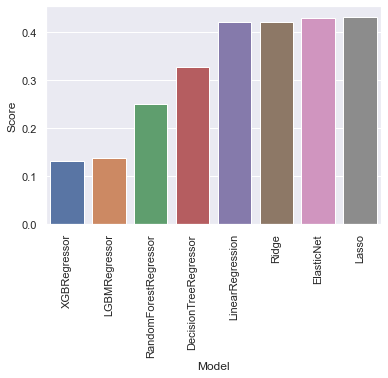

In [197]:
sns.barplot(x='Model',y='Score',data=result_df)
plt.xticks(rotation =90)

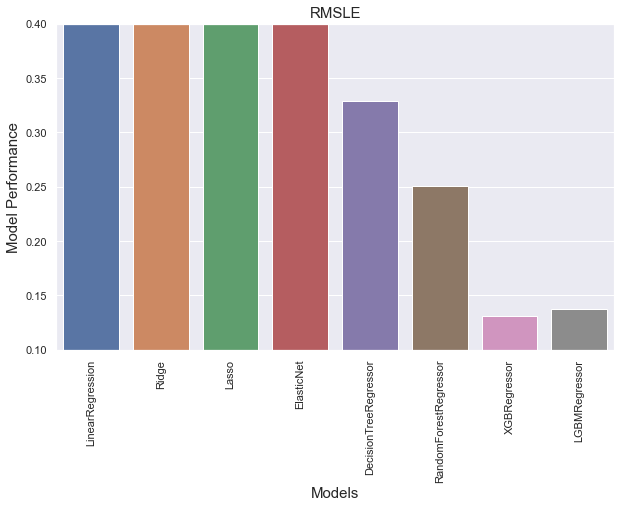

In [191]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.1, 0.4)
plt.title('RMSLE', fontsize=15)
plt.show()

# LGBM

In [192]:
drop_columns = ['거래일','제품한글명','모델번호','출시일','컬러']
test_df = test_df.drop(drop_columns,axis=1)

In [193]:
final_lgb_model = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

In [194]:
final_lgb_pred

array([12.54665039, 11.93225765, 12.10954099, ..., 12.86827822,
       11.97259163, 12.61916233])

In [199]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [202]:
importances_df = pd.DataFrame(columns=['column','importances'])
importances_df['column'] = train_X.columns
importances_df['importances'] = final_xgb_model.feature_importances_

In [205]:
importances_df = importances_df.drop(0,axis=0).reset_index(drop=True)
importances_df = importances_df.sort_values(by='importances').reset_index(drop=True)
importances_df

,column,importances
0,STEALTH,0.003804
1,ORANGE,0.004530
2,CORAL,0.005182
3,YELLOW,0.006565
4,STARFISH,0.006684
5,거래월,0.007793
6,PINK,0.011249
7,SILVER,0.012423
8,BROWN,0.012699
9,GREEN,0.013102


<AxesSubplot:ylabel='column'>

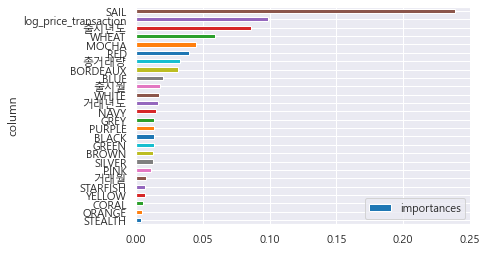

In [209]:
importances_df.plot("column", "importances", kind="barh", color=sns.color_palette("tab10"))

<BarContainer object of 28 artists>

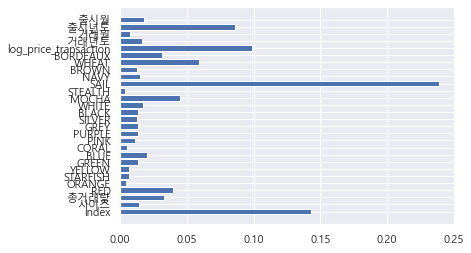

In [200]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

In [122]:
y_test = np.log1p(y_test)

In [124]:
result_df = pd.DataFrame(columns=['y_test','predict'])
result_df['y_test'] = y_test
result_df['predict'] = final_xgb_pred

In [126]:
result_df['difference'] = abs(result_df['y_test']-result_df['predict'])
print("-------오차-------")
result_df['difference'].mean()

-------오차-------


0.08614298698235329

In [ ]:
train_df[

In [235]:
real_test = train_df.loc[398,:]

C:\Users\gi257\AppData\Local\Temp/ipykernel_19160/3873406069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['거래월'] = 8


In [236]:
real_test = real_test.drop(['log_price'])
real_test = pd.DataFrame(real_test).T
real_test

,index,사이즈,총거래량,RED,ORANGE,STARFISH,YELLOW,GREEN,BLUE,CORAL,...,SAIL,NAVY,BROWN,WHEAT,BORDEAUX,log_price_transaction,거래년도,거래월,출시년도,출시월
398,804.0,260.0,2490.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,12.201065,2022.0,8.0,2020.0,11.0


In [238]:
real_predict = final_lgb_model.predict(real_test)

In [239]:
np.expm1(real_predict)

array([718266.64091408])